# Rapid Adiabatic Passage Simulations for $\text{CH}_4$

In this notebook, we will try to reproduce calculations and simulation presented by Rainer Beck *et al.* in *J.Chem.Phys* **140**, 034321 (2014) for preparation of quantum state specific reactants in a molecular beams by rapid adiabatic passage. 

In [1]:
# importing some paraphernelia 
import numpy as np
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='sans-serif', serif='computer modern')
import matplotlib.pyplot as plt
from scipy.constants import c, mu_0, epsilon_0, h, hbar

$$
w_{x}(0) = \frac{f\lambda}{r\pi}
$$

$$
w_{x}(z) = w_{x}(0)\sqrt{1+\frac{z^2}{z_R^2}}
$$

$$
z_{R} = \frac{\pi w_{x}(0)^2}{\lambda}
$$

$$
R(z) = z + \frac{z_{R}^2}{z}
$$

In [2]:
import os 
os.environ['OMP_NUM_THREADS'] = '4'
from rap_mb.cpp import *
from rap_mb.helpers import *


In [3]:
nu_bar = 3028.75 # cm^-1
wl_nm = 1/(nu_bar)*1e7 # nm
r = 0.2      # cm   
focal_lengths = [10, 25.4, 40, 65, 96] #cm
z = np.linspace(-20, 20, 5000) # cm
colors = {10.0:'red', 25.4:'black', 40.0:'green', 65.0:'mediumblue', 96.0:'purple'}

Text(0, 0.5, '$|R(z)|$ [cm]')

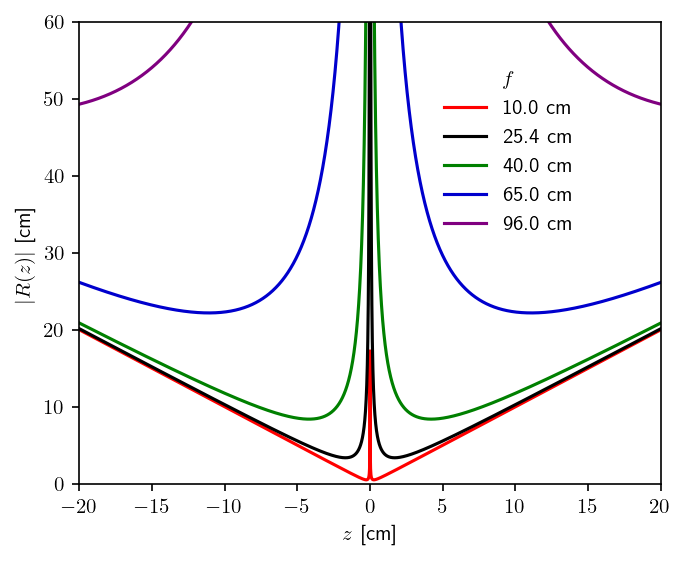

In [4]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = f, wl_nm, r
    label = '{f:2.1f} cm'.format(f=f)
    w0 = wl_nm*1e-7*f/(np.pi*r)
    ax.plot(z, abs(R(z, w0, wl_nm)), label=label, color=colors[f])
ax.set_ylim(0, 60)
ax.set_xlim(-20,20)
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.88,0.5], frameon=False, title=r'$f$')
ax.set_ylabel(r'$|R(z)|$ [cm]')

Text(0, 0.5, '$w_{x}(z)$ [mm]')

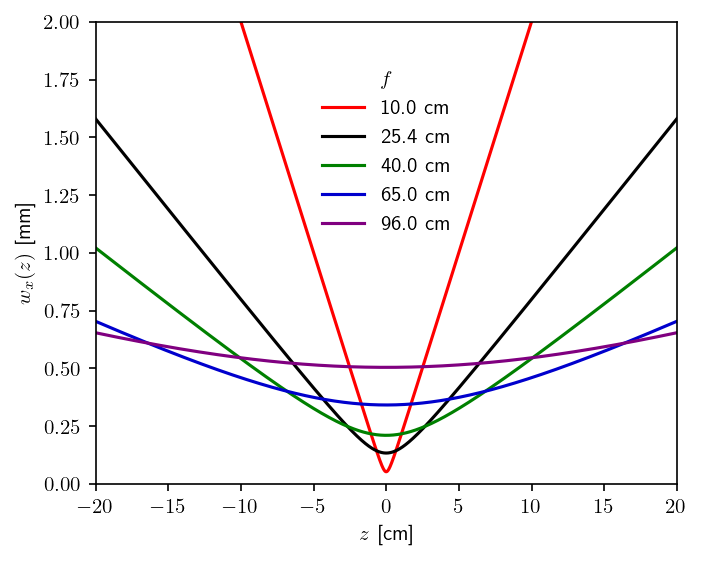

In [5]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = f, wl_nm, r
    label = '{f:2.1f} cm'.format(f=f)
    ax.plot(z, w(z, wl_nm, r, f, focused=True)*10, label=label, color=colors[f])
ax.set_ylim(0, 2.0)
ax.set_xlim(-20,20)
ax.set_xlabel(r'$z$ [cm]')
ax.legend(bbox_to_anchor=[.5,0.5], frameon=False, title=r'$f$')
ax.set_ylabel(r'$w_{x}(z)$ [mm]')

### Sweep rates

$$
\frac{d\Phi}{dt} = \frac{v_x^2\omega_{21}}{R(z)c}
$$

$$
T_{trans} = \frac{2w_{x}(z)}{v_{x}}
$$

The total sweep experienced by the molecule from the curved wavefronts can be calculated as 
$$
\frac{d\Phi}{dt}T_{trans}
$$

The frequency sweep experienced by the molecule at a time t is given by  
$$
\Delta(t) = \omega_{21} - \omega_{L} - \frac{d\Phi}{dt}t
$$

where $\omega_{21}$ is the frequency of the transition, $\omega_L$ the laser frequency. So, if the detuning is zero *i.e.* if the laser is resonant with the transition and, if there is no divergence in the molecular beam, the sweep is only due to the curved wavefronts.


However, there's usually an angular divergence associated with the molecular beam and, this gives rise to a Doppler shift associated with the component of velocity that is parallel ($v_{z}$) to the direction of propagation of the laser field.

$$
\Delta(t) = \frac{v_z \omega_{21}}{c} - \frac{v_x^2\omega_{21}}{R(z)c}t
$$

In [6]:
vx = 2056
z = np.linspace(0,20, 2000)

/home/vijay/Desktop/rap-mb/rap_mb/helpers.py:34: RuntimeWarning: divide by zero encountered in divide
  R =  z + zr(w0, wl_nm)**2/z


Text(0, 0.5, '${d\\phi}/{dt}$ [Hz s$^{-1}$]')

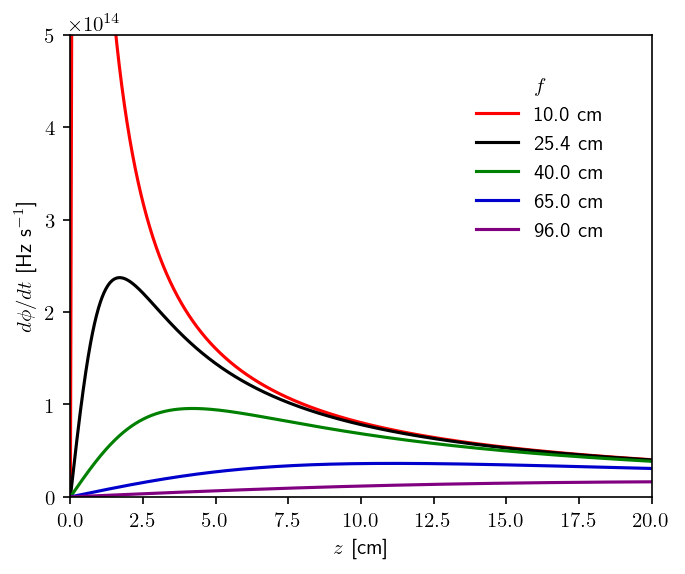

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = wl_nm, r, f
    label = '{f:2.1f} cm'.format(f=f)
    ax.plot(z, sweep_rate(z, vx, params), label=label, color=colors[f])
ax.set_xlim(0, 20)
ax.set_ylim(0, 5e14)
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.95,0.95], frameon=False,title=r'$f$')
ax.set_ylabel(r'${d\phi}/{dt}$ [Hz s$^{-1}$]')

Text(0, 0.5, '$T_\\textit{\\tiny trans} \\ {d\\phi}/{dt}$ [Hz s$^{-1}$]')

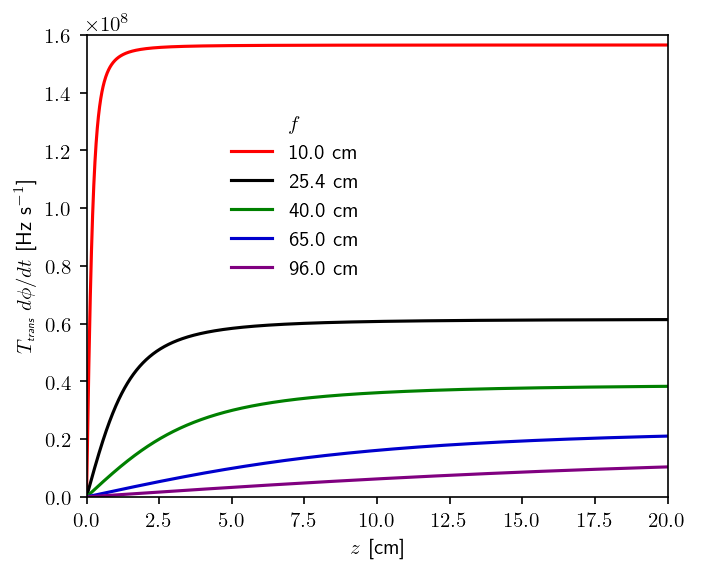

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = wl_nm, r, f
    label = '{f:2.1f} cm'.format(f=f)
    tr = transit_time(z,vx,params)
    ax.plot(z, tr*sweep_rate(z, vx, params), label=label, color=colors[f])
ax.set_xlim(0,20)
ax.set_ylim(0,1.6e8)
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.5,0.65], frameon=False,title=r'$f$')
ax.set_ylabel(r'$T_\textit{\tiny trans} \ {d\phi}/{dt}$ [Hz s$^{-1}$]')

Text(0, 0.5, '$\\Omega(z)$ MHz')

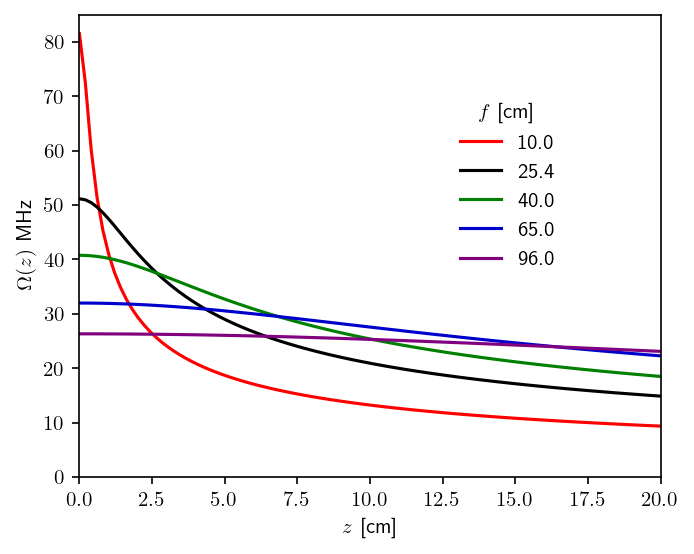

In [9]:
dipole = 1.8e-31 # C-m
P = 0.5
Nz = 100
v = 2000
delta_v = 10
divergence = 0.700
z = np.linspace(0, 20, Nz)
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = wl_nm, r,f
    label = '{f:2.1f}'.format(f=f)
    vel_xyz = sample_velocities(v, delta_v, divergence)
    E0 = Exy(0, z, 0.5, vel_xyz, params)
    omega_r = E0*dipole/hbar
    ax.plot(z, omega_r/1e6, label=label, color=colors[f])
ax.set_xlim(0,20)
ax.set_ylim(0,85.0)
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.85,0.85], frameon=False,title=r'$f$ [cm]')
ax.set_ylabel(r'$\Omega(z)$ MHz')

Text(0.5, 0.98, '$E_{avg}$ felt by molecules')

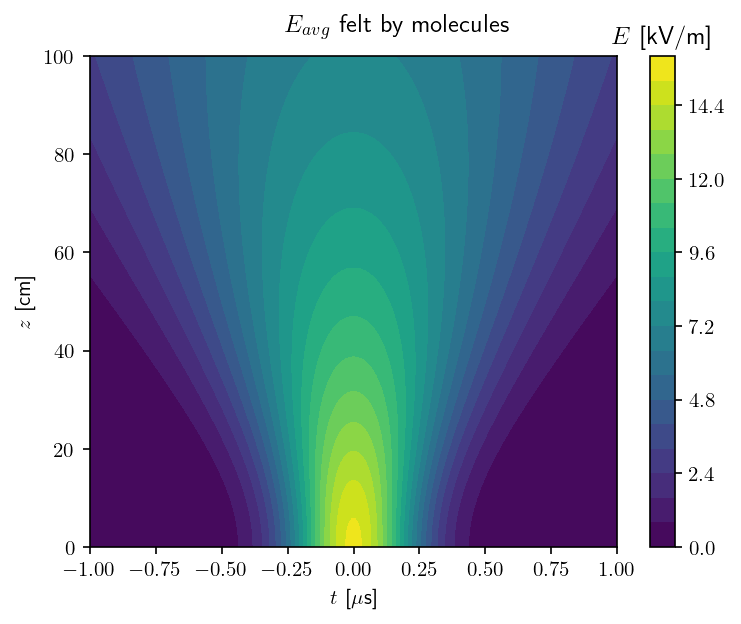

In [10]:
Nt = 200
Nz = 100
N_sample = 10000
t = np.linspace(-1e-6, 1e-6, Nt)
z = np.linspace(0, 100, Nz)
Z, T = np.meshgrid(z, t)
E = np.empty((Nt, Nz), dtype=np.float64)
velocities = np.empty((N_sample, 3), dtype=np.float64)
for i in range(N_sample):
    vel_xyz = sample_velocities(v, delta_v, divergence)
    velocities[i,:] = vel_xyz
    E += Exy(T, Z, 0.5, vel_xyz, params)/1e3
E = E/N_sample

fig, ax = plt.subplots(figsize=(5,4))
cs = ax.contourf(T/1e-6, Z, E, levels=20)
cbar = plt.colorbar(cs, spacing='proportional')
cbar.ax.set_title(r'$E$ [kV/m]')
fig.tight_layout()
ax.set_xlabel(r'$t$ [$\mu$s]')
ax.set_ylabel(r'$z$ [cm]')
fig.suptitle(r'$E_{avg}$ felt by molecules')

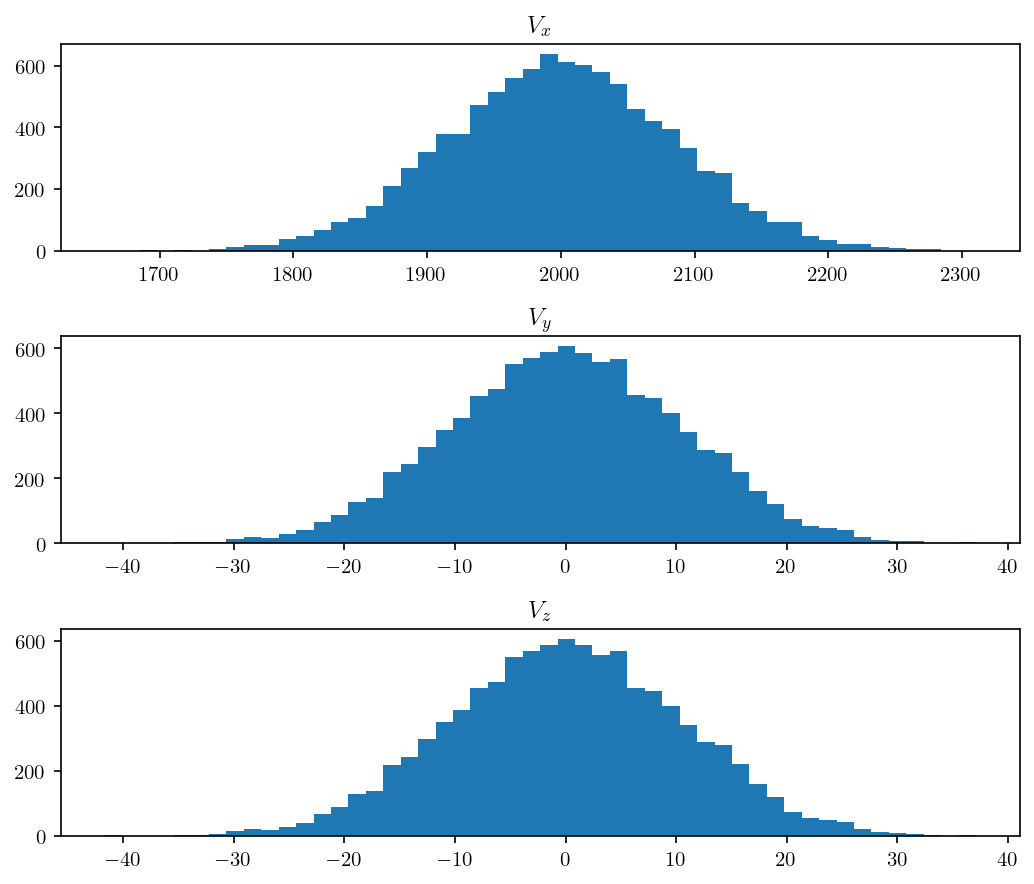

In [11]:
fig, ax = plt.subplots(3,1, figsize=(7, 6))
ax[0].set_title(r'$V_{x}$')
ax[1].set_title(r'$V_{y}$')
ax[2].set_title(r'$V_{z}$')
ax[0].hist(velocities[:,0], bins=50)
ax[1].hist(velocities[:,1],bins=50)
ax[2].hist(velocities[:,2],bins=50)
fig.tight_layout()

## Optical Bloch Equations

Now, let's solve the optical Bloch equations for the two-level system.

$$
\begin{align*}

\frac{dU}{dt} &= -V \\

\frac{dV}{dt} &= \Delta U + \Omega W \\

\frac{dW}{dt} &= -\Omega V

\end{align*}
$$


In [12]:
input = {
        "wavelength_nm": wl_nm,
        "beam_radius": 0.20,
        "power": 0.200,
        "dipole_mom": 1.8e-31,
        "velocity_fwhm": 200.0,
        "divergence_fwhm": 0.7,
        "N_samples": 100,
        "U0": 0.0,
        "V0": 0.0,
        "W0": -1.0,
        "rel_tol":1e-6,
        "abs_tol":1e-8,
        "max_tsteps":50000,
        "dt_max":50.0e-6,
        "N_t" : 100,
}

In [13]:
Nz = 10
input['velocity'] = 2056.00
input['power'] = 0.200
focal_length = np.array([10.0, 25.4, 40.0, 65.0, 96.0]) 
z = np.linspace(0.1, 70.0, Nz)
data1 = {'z': z}
focal_length_data = {}
for f in focal_length:
    input['focal_length'] = f
    n1 = np.empty(Nz, dtype=np.float64)
    for i in range(Nz):
        input['zi'] = z[i]
        n1[i] = monte_carlo(input)
    focal_length_data[f] = n1
data1['focal_length'] = focal_length_data 

(0.0, 1.05)

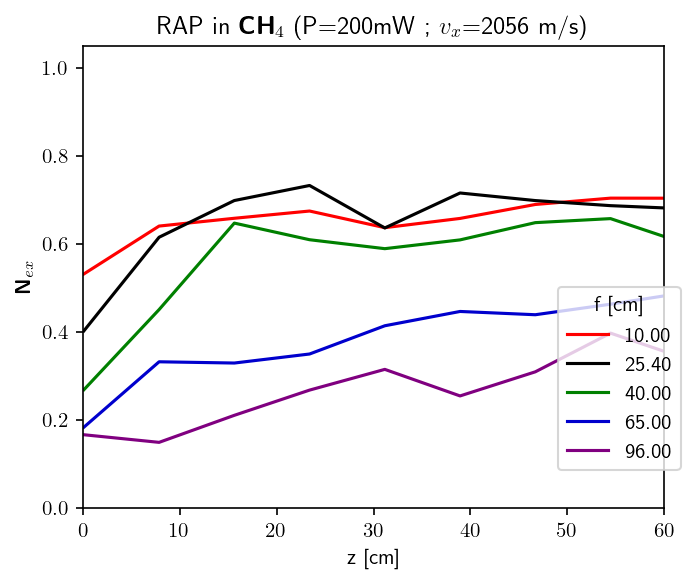

In [14]:
title = r"RAP in $ \textbf{CH}_{4}$ (P=200mW ; $v_{x}$=2056 m/s)"
fig, ax = plot_property_data(data1, x_key='z', param_key='focal_length', title=title, legend_title='f [cm]', xlabel='z [cm]',xlim=[0, 60], figsize=(5,4), colors=colors)
ax.set_ylim(0, 1.05)

In [15]:
fname = "../data/methane/p_2e-1_v_2000_f_fxn_z.npy"
np.save(fname, data1)

In [16]:
Nz = 40
input['velocity'] = 2056.00
input['power'] = 0.500
focal_length = np.array([10.0, 25.4, 40.0, 65.0, 96.0]) 
z = np.linspace(0.1, 60.0, Nz)
data2 = {'z': z}
focal_length_data = {}
for f in focal_length:
    input['focal_length'] = f
    n1 = np.empty(Nz, dtype=np.float64)
    for i in range(Nz):
        input['zi'] = z[i]
        n1[i] = calculate_ensemble_average(input)
    focal_length_data[f] = n1
data2['focal_length'] = focal_length_data 

(0.0, 1.05)

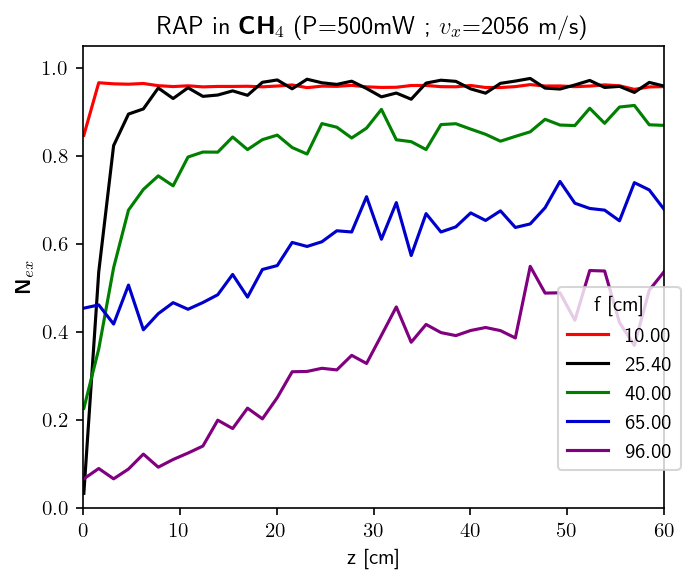

In [17]:
title = r"RAP in $ \textbf{CH}_{4}$ (P=500mW ; $v_{x}$=2056 m/s)"
fig, ax = plot_property_data(data2, x_key='z', param_key='focal_length',
                             title=title, legend_title='f [cm]', 
                             xlabel='z [cm]',xlim=[0, 60], figsize=(5,4), colors=colors)
ax.set_ylim(0, 1.05)

In [18]:
fname = "../data/methane/p_5e-1_v_2000_f_fxn_z.npy"
np.save(fname, data1)

In [19]:
Np = 50
input['focal_length'] = 25.4
input['velocity'] = 2056.00
power = np.linspace(0.0, 1.00, Np)
data2 = {'power': power*1000}
power_data = {}
z = np.array([0.1, 1.25, 2.5, 5.0])
for zi in z:
    input['zi'] = zi
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[zi] = n1
data2['z'] = power_data

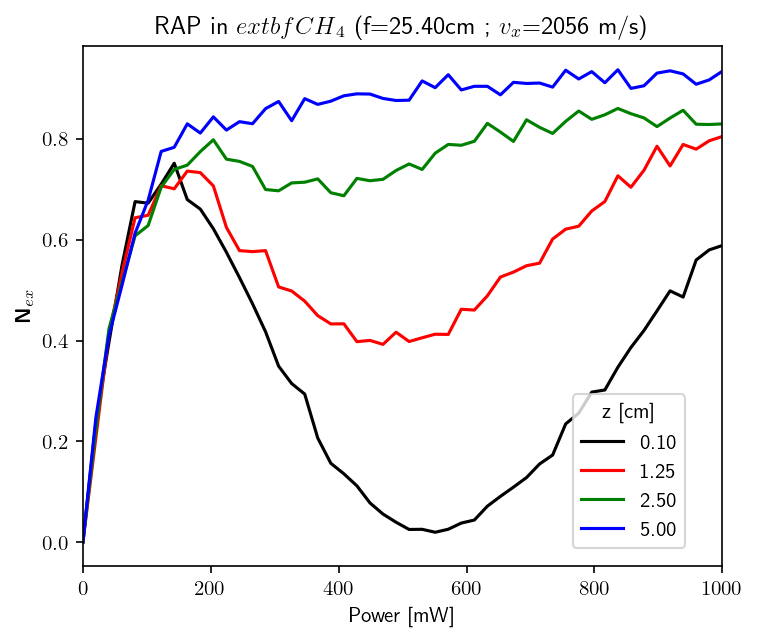

In [20]:
title = "RAP in $ \textbf{CH}_{4}$ (f=25.40cm ; $v_{x}$=2056 m/s)"
colors = {0.1:"black",1.25:"red",2.5:"green",5.0:"blue"}
fig, ax = plot_property_data(data2, x_key='power', param_key='z',title=title, legend_title='z [cm]', 
xlabel='Power [mW]',xlim=[0, 1000],
figsize=(5.5,4.5), legend_loc=[0.75,0.35], colors=colors)

In [21]:
Np = 50
input['velocity'] = 2056.00
power = np.linspace(0.0, 1.00, Np)
data3 = {'power':power}
# curve 1
input['focal_length'] = 25.4
input['zi'] = 10.6
n1 = np.empty(Np, dtype=np.float64)
for i in range(Np):
    input['power'] = power[i]
    n1[i] = calculate_ensemble_average(input)
data3['curve1'] = n1
# curve 2
input['focal_length'] = 96.0
input['zi'] = 57.0
n1 = np.empty(Np, dtype=np.float64)
for i in range(Np):
    input['power'] = power[i]
    n1[i] = calculate_ensemble_average(input)
data3['curve2'] = n1

(0.0, 1.05)

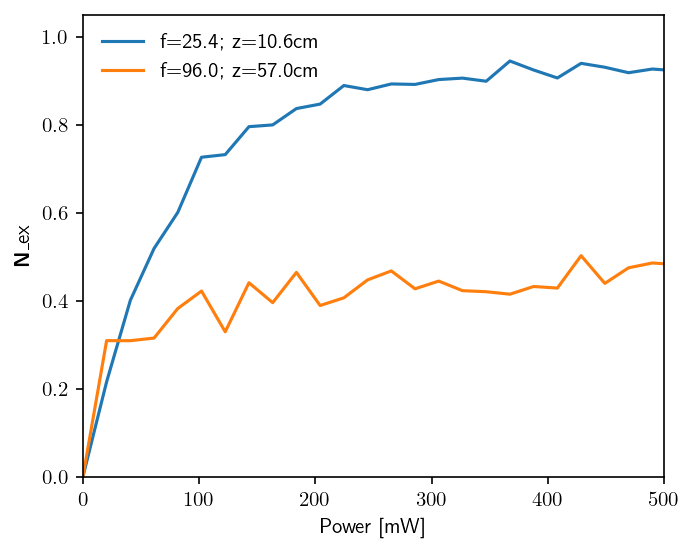

In [22]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(power*1000, data3['curve1'], label='f=25.4; z=10.6cm')
ax.plot(power*1000, data3['curve2'], label='f=96.0; z=57.0cm')
ax.set_xlabel('Power [mW]')
ax.set_ylabel(r" \textbf{N}_{ex}")
ax.legend(frameon=False)
ax.set_xlim(0, 500)
ax.set_ylim(0, 1.05)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, atomic_mass

In [24]:
def velocity_dist(v, theta, params):
    m, T_para, T_perp, U, n = params
    v_para = v*np.cos(theta)
    v_perp = v*np.sin(theta)
    c_para = np.sqrt(2*k*T_para/m)
    c_perp = np.sqrt(2*k*T_perp/m)
    f =  v**3/np.sqrt(np.pi)**3 * 1/(c_para*c_perp**2) * np.exp(-(v_perp/c_perp)**2) * np.exp(-((v_para-U)/c_para)**2)
    return f

In [25]:
m = atomic_mass*16.0 # Methane mass
v_mean = 2000.0
v_fwhm = 200.0
ang_fwhm = 0.7
def fv(v_mean, v_fwhm, ang_fwhm, m, k, n):
    v_sigma = v_fwhm/2.355
    ang_sigma = ang_fwhm/2.355
    v = np.random.normal(v_mean, v_sigma)
    theta = np.random.normal(0.0, ang_sigma)*np.pi/180
    v_para = v*np.cos(theta)
    v_perp = v*np.sin(theta)
    T_para = m/k *(np.cos(theta)*v_sigma - v*np.sin(theta)*ang_sigma*np.pi/180)**2
    T_perp = m/k *(np.sin(theta)*v_sigma + v*np.cos(theta)*ang_sigma*np.pi/180)**2
    prefactor = (n)*np.sqrt(m/(2*np.pi*k*T_para))*(m/(2*np.pi*k*T_perp))
    exp_term = np.exp(-m*(v_para - v_mean)**2/(2*k*T_para) - m/(2*k*T_perp)*(v_perp)**2)
    fv = prefactor*exp_term
    print(T_para, T_perp)
    return fv

fv(v_mean, v_fwhm, ang_fwhm, m, k, n=1e5)

13.874083534503571 0.23050133966563824


0.35936315581193656

In [26]:
atomic_mass

1.6605390666e-27